In [47]:
import numpy as np
import pandas as pd
import polars as pl
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
os.chdir('..')
os.chdir('src')
from env import BlackjackEnv


In [48]:
def parse_strategy_csv(file_path):
    try:
        # Read the CSV file
        df = pl.read_csv(file_path)
        
        # Initialize the basic strategy dictionary
        strategy = {}
        
        # Process the dataframe into a dictionary
        for row in df.iter_rows(named=True):
            # Parse the state from string format like '(12, 10, 0)'
            # Extract the state values
            state_str = row['State'].strip('()').split(', ')

            # state_str = row['State'].strip('[]').split()
            player_sum = int(state_str[0])
            dealer_card = int(state_str[1])
            usable_ace = int(state_str[2])
            
            # Create the state key
            state_key = (player_sum, dealer_card, usable_ace)
            
            # Get the action values
            stand_value = row['Action 0 (Stand)']
            hit_value = row['Action 1 (Hit)']
            # Check if the column for double action exists
            if 'Action 2 (Double)' in row:
                double_value = row['Action 2 (Double)']
            else:
                # If not present, set double value to None or some default
                double_value = None
            
            # Store the action values in a dictionary
            strategy[state_key] = {
                0: stand_value,  # Stand
                1: hit_value,    # Hit
                2: double_value   # Double
            }
            
        return strategy
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

In [49]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1],
    "actions": ["stand", "hit", "double"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)


### Initialization of Q table

In [ ]:
# Helper function to determine if doubling down is optimal according to basic strategy
def is_double_recommended(state):
    player_sum, dealer_card, usable_ace = state
    
    if not usable_ace:  # Hard totals
        # Classic double down opportunities for hard totals (9-11 vs. dealer's weak cards)
        if player_sum == 11:
            return dealer_card <= 10  # Double on 11 vs. almost anything
        elif player_sum == 10:
            return 2 <= dealer_card <= 9  # Double on 10 vs. 2-9
        elif player_sum == 9:
            return 3 <= dealer_card <= 6  # Double on 9 vs. 3-6
    else:  # Soft totals
        # Common double down spots for soft totals
        if player_sum in [17]:  # A-6, A-7 #works better with 17, 18
            return 3 <= dealer_card <= 6
        elif player_sum in [15, 16]:  # A-4, A-5
            return 4 <= dealer_card <= 6
        elif player_sum in [13, 14]:  # A-2, A-3
            return 5 <= dealer_card <= 6
    
    return False

In [51]:
os.chdir('..')
os.chdir('strategies')
# read the reference Q-table from the CSV file
Q_ref = parse_strategy_csv('dq_hit_stand_strat.csv')


In [52]:
# Generate relevant states - focusing on decision points that matter
states = []
# For hard totals (no usable ace), only track 12-21
# Below 12, the optimal play is always hit
for player_sum in range(5, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 0))  # Hard total

# For soft totals (with usable ace), track 12-21
# Soft totals below 12 are impossible (A+1 = 12)
for player_sum in range(12, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 1))  # Soft total

In [53]:
# Initialize Q-tables with strategic initialization
q_table = {}
q_table2 = {}  # Second Q-table for double Q-learning

print("Initializing Q-tables with hybrid strategy...")
# Perform strategic initialization for all states
for state in states:
    player_sum, dealer_card, usable_ace = state
    
    # Start with existing hit/stand values from previous learning
    if state in Q_ref:
        # Use previously learned values for stand and hit
        q_table[state] = {
            0: Q_ref[state][0],  # Stand value
            1: Q_ref[state][1],  # Hit value
        }
    else:
        # Default initialization if state wasn't in previous learning
        if player_sum >= 20:
            q_table[state] = {0: 0.5, 1: -0.1}  # Prefer stand for high sums
        elif player_sum < 12:
            q_table[state] = {0: -0.1, 1: 0.5}  # Prefer hit for low sums
        else:
            q_table[state] = {0: 0.0, 1: 0.0}  # Neutral for middle sums
    
    # Now add the double down values with strategic initialization
    best_hit_stand_value = max(q_table[state][0], q_table[state][1])
    # Use our heuristic function if basic strategy values are not available
    if is_double_recommended(state):
        q_table[state][2] = best_hit_stand_value + 0.3
    else:
        q_table[state][2] = best_hit_stand_value - 0.2

# Create second Q-table for double Q-learning
q_table2 = copy.deepcopy(q_table)

Initializing Q-tables with hybrid strategy...


In [54]:
# Track state-action visit counts for adaptive learning rates
visit_counts = {}
for state in states:
    for action in [0, 1, 2]:  # Stand, Hit, Double
        visit_counts[(state, action)] = 0

### Hyperparameters

In [55]:
# Improved hyperparameters
initial_lr = 0.1             # Learning rate
lr_decay_rate = 0.00005      # Gentler decay rate
gamma = 1.0                  # Higher discount factor - long-term rewards matter mor
initial_epsilon = 1.0        # Start with 100% exploration
epsilon_min = 0.01           # Minimum exploration rate
epsilon_decay = 0.99995      # Much slower decay rate

# Double down specific parameters
double_exploration_bias = 0.6   # High bias toward double down during exploration
hit_stand_lr_multiplier = 0.05  # Very low learning rate for hit/stand (5% of normal)
double_down_lr_boost = 2.0      # Higher learning rate for double down in uncertain areas

### Helper functions Strategy Q-table

In [56]:

# Modified state representation - focusing on meaningful game states
def get_state_features(full_state):
    # Extract just player sum, dealer card, and usable ace
    player_sum = full_state[0]
    dealer_card = full_state[1]
    usable_ace = full_state[2]
    return (player_sum, dealer_card, usable_ace)


In [57]:
def get_adaptive_lr(state, action, base_lr):
    """Get state-action specific learning rate based on visit count"""
    key = (state, action)
    count = visit_counts.get(key, 0) + 1
    # Decay learning rate based on visit count, but maintain a minimum rate
    return max(base_lr / (1 + 0.005 * count), base_lr * 0.1)

In [58]:
def get_q_values(state_features, q_table=q_table):
    """Get Q-values for a given state"""
    if state_features in q_table:
        return np.array([q_table[state_features][0], q_table[state_features][1], q_table[state_features][2]])
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5, 0.0])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1, 0.0])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0, 0.0])  # Neutral for middle sums

In [59]:
def update_q_value(state_features, action, reward, next_state_features, lr, q_table=q_table, q_table_target=q_table2):
    """Update Q-value for state-action pair using Double Q-learning"""
    if state_features not in q_table:
        return  # State not in our table
    
    # Current Q-value
    current_q = q_table[state_features][action]
    
    # If next_state_features is None, this is a terminal state
    if next_state_features is None:
        # Terminal state - no future rewards
        new_q = current_q + lr * (reward - current_q)
    else:
        # Get the next state's best action from current Q-table
        next_q_values = get_q_values(next_state_features, q_table)
        best_next_action = np.argmax(next_q_values)
        
        # Get Q-value for best action from target Q-table
        next_q_values_target = get_q_values(next_state_features, q_table_target)
        max_next_q = next_q_values_target[best_next_action]
        
        # Q-learning update formula with future rewards
        new_q = current_q + lr * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table entry
    q_table[state_features][action] = new_q
    
    # Track visit counts
    visit_counts[(state_features, action)] = visit_counts.get((state_features, action), 0) + 1
    
    return q_table

In [60]:
def smart_exploration(state_features, epsilon):
    """Strategic exploration with bias toward double in promising situations"""
    
    # Identify promising double down situations
    promising_double = is_double_recommended(state_features)
    
    if np.random.rand() < epsilon:  # Exploration phase
        if promising_double:
            # Higher bias toward double in promising situations
            if np.random.rand() < double_exploration_bias:
                return 2  # Double down
        else:
            # Standard exploration with lower double bias elsewhere
            if np.random.rand() < (double_exploration_bias * 0.5):
                return 2  # Double down
        
        # Otherwise, choose randomly among all actions
        return np.random.choice([0, 1, 2])
    else:
        # Exploitation - choose best action
        q_values1 = get_q_values(state_features, q_table)
        q_values2 = get_q_values(state_features, q_table2)
        avg_q_values = (q_values1 + q_values2) / 2
        return np.argmax(avg_q_values)

### Training phase 1: biased exploration of double down

In [61]:
# TRAINING PROCESS
print("Starting training with optimized double down learning...")
epsilon = initial_epsilon
lr = initial_lr

stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'double actions': 0,
    'double wins': 0,
    'double losses': 0,
    'double draws': 0
}

# Parameters for training
n_episodes = 2000000
convergence_threshold = 0.001
convergence_check_interval = 10000
convergence_required_count = 3

# Keep previous Q-table for comparison
previous_q = copy.deepcopy(q_table)
convergence_count = 0
converged = False
episode = 0

# Training loop
while episode < n_episodes and not converged:
    # Reset environment
    env.reset()
    bet_index = env.bet_space.sample()
    bet_amount = env.bets[bet_index]
    state, reward, done = env.step(bet_index, action_type="bet")
    
    if done:  # Natural blackjack or dealer natural
        if reward > 0:
            stats['wins'] += 1
        elif reward == 0:
            stats['draws'] += 1
        else:
            stats['losses'] += 1
        episode += 1
        continue
    
    state_features = get_state_features(state)
    
    # Play through the hand
    while not done:
        if state_features[0] < 9:
        # Always hit this state as it's not relevant for our training
            next_state, _, _ = env.step(1, action_type="move")
            next_state_features = get_state_features(next_state) if not done else None
            state = next_state
            state_features = next_state_features if next_state is not None else None
            continue
        else:
            # Use smart exploration strategy
            action = smart_exploration(state_features, epsilon)
        
        # Track double down actions
        original_bet = bet_amount
        if action == 2:
            stats['double actions'] += 1
            bet_amount *= 2
        
        # Take action
        next_state, reward, done = env.step(action, action_type="move")
        next_state_features = get_state_features(next_state) if not done else None
        
        # Apply adaptive learning rate
        adaptive_lr = get_adaptive_lr(state_features, action, lr)
        
        # Add reward shaping for double down in correct situations
        shaped_reward = reward
        if action == 2 and is_double_recommended(state_features):
            # Small bonus for theoretically correct doubles to help convergence
            shaped_reward += 0.05
        
        # Update Q-values (randomly choose which table to update)
        if np.random.rand() < 0.5:
            q_table = update_q_value(state_features, action, shaped_reward * bet_amount, 
                                     next_state_features, adaptive_lr, q_table, q_table2)
        else:
            q_table2 = update_q_value(state_features, action, shaped_reward * bet_amount, 
                                     next_state_features, adaptive_lr, q_table2, q_table)
        
        # Track outcomes of double down actions
        if done and action == 2:
            if reward > 0:
                stats['double wins'] += 1
            elif reward == 0:
                stats['double draws'] += 1
            else:
                stats['double losses'] += 1
        
        # Track overall outcomes
        if done:
            if reward > 0:
                stats['wins'] += 1
            elif reward == 0:
                stats['draws'] += 1
            else:
                stats['losses'] += 1
        
        # Move to next state
        state = next_state
        state_features = next_state_features if next_state is not None else None
        
        if state_features is None:
            break
    
    # Update stats and decay parameters
    episode = episode + 1
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    lr = initial_lr / (1 + lr_decay_rate * episode)
    
    # Check for convergence periodically
    if episode % convergence_check_interval == 0 and episode > 0:
        # Focus on double down action convergence
        diff_double = [q_table[state][2] - previous_q[state][2] for state in q_table if state in previous_q]
        max_diff_double = max(abs(diff) for diff in diff_double) if diff_double else 0
        
        # Calculate double down statistics
        double_ratio = stats['double actions'] / episode * 100
        double_win_rate = stats['double wins'] / stats['double actions'] * 100 if stats['double actions'] > 0 else 0
        
        print(f"Episode {episode}, max Double Q-value change: {max_diff_double:.6f}")
        print(f"Double actions: {stats['double actions']} ({double_ratio:.2f}% of episodes)")
        print(f"Double win rate: {double_win_rate:.2f}%")
        print(f"Overall win rate: {stats['wins']/episode:.4f}")
        
        if max_diff_double < convergence_threshold:
            convergence_count += 1
            print(f"Convergence count: {convergence_count}/{convergence_required_count}")
            if convergence_count >= convergence_required_count:
                print(f"Converged after {episode} episodes!")
                converged = True
        else:
            convergence_count = 0
        
        # Store current Q-values for next comparison
        previous_q = copy.deepcopy(q_table)
    
    episode += 1

# Final stats
print(f"\nTraining complete after {episode} episodes.")
print(f"Win rate: {stats['wins']/episode:.4f}")
print(f"Draw rate: {stats['draws']/episode:.4f}")
print(f"Loss rate: {stats['losses']/episode:.4f}")
print(f"Double down win rate: {stats['double wins']/stats['double actions']:.4f} if taken")

Starting training with optimized double down learning...
Episode 30000, max Double Q-value change: 2.117746
Double actions: 7256 (24.19% of episodes)
Double win rate: 29.91%
Overall win rate: 0.1742
Episode 40000, max Double Q-value change: 0.497617
Double actions: 8986 (22.46% of episodes)
Double win rate: 30.46%
Overall win rate: 0.1782
Episode 50000, max Double Q-value change: 0.279741
Double actions: 10527 (21.05% of episodes)
Double win rate: 30.69%
Overall win rate: 0.1822
Episode 80000, max Double Q-value change: 0.399523
Double actions: 14029 (17.54% of episodes)
Double win rate: 32.08%
Overall win rate: 0.1909
Episode 90000, max Double Q-value change: 0.115956
Double actions: 14911 (16.57% of episodes)
Double win rate: 32.39%
Overall win rate: 0.1927
Episode 110000, max Double Q-value change: 0.125155
Double actions: 16292 (14.81% of episodes)
Double win rate: 33.17%
Overall win rate: 0.1976
Episode 120000, max Double Q-value change: 0.120557
Double actions: 16976 (14.15% of e

### Second training phase

In [62]:
# Track state-action visit counts for adaptive learning rates
visit_counts = {}
for state in states:
    for action in [0, 1, 2]:  # Stand, Hit, Double
        visit_counts[(state, action)] = 0

In [63]:
# Training loop with convergence check
print("Starting second phase training...")
epsilon = initial_epsilon
lr = initial_lr
stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money won': 0,
    'money lost': 0,
    'doubles': 0
}

# Parameters for training
n_episodes = 2000000
convergence_threshold = 0.001
convergence_check_interval = 10000
convergence_required_count = 3

# Keep previous Q-table for comparison
previous_q = copy.deepcopy(q_table)
convergence_count = 0
converged = False
episode = 0

#first training phase only for the Q-table with fixed betting strategy
while episode < n_episodes and not converged:

    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:  # Natural blackjack or dealer natural
        if reward > 0:
            stats['wins'] += 1
            stats['money won'] += reward * bet_amount
        elif reward == 0:
            stats['draws'] += 1
        else:
            stats['losses'] += 1
            stats['money lost'] += abs(reward) * bet_amount
        episode += 1
        continue
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        
        if state_features[0] < 9:
        # Always hit this state as it's not relevant for our training
            next_state, _, _ = env.step(1, action_type="move")
            next_state_features = get_state_features(next_state) if not done else None
            state = next_state
            state_features = next_state_features if next_state is not None else None
            continue
        
        # Epsilon-greedy action selection
        elif np.random.rand() < epsilon:
            action = env.move_space.sample()  # Random action
        else:
            q_values1 = get_q_values(state_features, q_table)
            q_values2 = get_q_values(state_features, q_table2)
            q_values = (q_values1 + q_values2)/2
            action = np.argmax(q_values)  # Greedy action
        
        if action == 2:
            # Double down action
            bet_amount *= 2
            stats['doubles'] += 1
        
        # Take action
        next_state, reward, done = env.step(action, action_type="move")
        next_state_features = get_state_features(next_state) if not done else None

        # Get adaptive learning rate for this state-action pair
        adaptive_lr = get_adaptive_lr(state_features, action, lr)

        # Randomly decide which Q-table to update (Double Q-learning)
        # print(f"State: {state_features}, Action: {action}, Done: {done}, Reward: {reward}, Next State: {next_state_features}")
        if np.random.rand() < 0.5:
            # print("Updating Q-table 1")
            q_table = update_q_value(state_features, action, reward*bet_amount, next_state_features, 0.25*adaptive_lr, q_table, q_table2)
        else:
            # print("Updating Q-table 2")
            q_table2 = update_q_value(state_features, action, reward*bet_amount, next_state_features, 0.25*adaptive_lr, q_table2, q_table)
            
        # Track outcomes
        if done:
            if reward > 0:
                stats['wins'] += 1
                stats['money won'] += reward * bet_amount
            elif reward == 0:
                stats['draws'] += 1
            else:
                stats['losses'] += 1
                stats['money lost'] += abs(reward) * bet_amount
        
        state = next_state
        state_features = next_state_features if next_state is not None else None
        
        if state_features is None:
            # print(f"Entered break condition with done being {done}")
            break
    
    # Decay epsilon and learning rate
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    lr = initial_lr / (1 + lr_decay_rate * episode)
    
    # Check for convergence periodically
    if episode % convergence_check_interval == 0 and episode > 0:
        # Calculate the maximum absolute difference between current and previous Q-values
        # Compute differences for "Stand" (action 0) and "Hit" (action 1)
        diff_stand = [q_table[state][0] - previous_q[state][0] for state in q_table if state in previous_q]
        diff_hit = [q_table[state][1] - previous_q[state][1] for state in q_table if state in previous_q]
        
        # Calculate the maximum absolute differences
        max_diff_stand = max(abs(diff) for diff in diff_stand) if diff_stand else 0
        max_diff_hit = max(abs(diff) for diff in diff_hit) if diff_hit else 0
        max_diff = max(max_diff_stand, max_diff_hit)
        
        if max_diff < convergence_threshold:
            convergence_count += 1
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f} (convergence count: {convergence_count}/{convergence_required_count})")
            if convergence_count >= convergence_required_count:
                print(f"Converged after {episode} episodes (max Q-value change: {max_diff:.6f})")
                converged = True
        else:
            convergence_count = 0
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f}")
        
        # Store current Q-values for next comparison
        previous_q = copy.deepcopy(q_table)
    
    episode += 1

# Final statistics
total_episodes = episode
print(f"Training complete after {total_episodes} episodes.")
print(f"Win rate: {stats['wins']/total_episodes:.4f}")
print(f"Draw rate: {stats['draws']/total_episodes:.4f}")
print(f"Loss rate: {stats['losses']/total_episodes:.4f}")
print(f"Total money won: {stats['money won']}")
print(f"Total money lost: {stats['money lost']}")
print(f"Doubles: {stats['doubles']:.4f} if taken")

Starting second phase training...
Episode 10000, max Q-value change: 0.198499
Episode 20000, max Q-value change: 0.169481
Episode 30000, max Q-value change: 0.098644
Episode 40000, max Q-value change: 0.075731
Episode 50000, max Q-value change: 0.048693
Episode 60000, max Q-value change: 0.036700
Episode 70000, max Q-value change: 0.024966
Episode 80000, max Q-value change: 0.024182
Episode 90000, max Q-value change: 0.014678
Episode 100000, max Q-value change: 0.019468
Episode 110000, max Q-value change: 0.015239
Episode 120000, max Q-value change: 0.012821
Episode 130000, max Q-value change: 0.009757
Episode 140000, max Q-value change: 0.011762
Episode 160000, max Q-value change: 0.009584
Episode 170000, max Q-value change: 0.008999
Episode 180000, max Q-value change: 0.005741
Episode 190000, max Q-value change: 0.005632
Episode 200000, max Q-value change: 0.007196
Episode 210000, max Q-value change: 0.004814
Episode 220000, max Q-value change: 0.005779
Episode 230000, max Q-value ch

### Testing Q-table win rate

In [64]:
# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")

eval_stats = {
    'eval wins': 0,
    'eval draws': 0,
    'eval losses': 0,
    'money won': 0,
    'money lost': 0,
    'doubles': 0,
    'double win amount': 0,
    'double loss amount': 0
}

eval_episodes = 1000000

for _ in range(eval_episodes):
    env.reset()
    bet_index = env.bet_space.sample()
    bet_amount = env.bets[bet_index]
    state, reward, done = env.step(bet_index, action_type="bet")
    
    if done:
        if reward > 0:
            eval_stats['eval wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['eval draws'] += 1
        else:
            eval_stats['eval losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount
    
    state_features = get_state_features(state)

    # Evaluation episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values1 = get_q_values(state_features, q_table)
        q_values2 = get_q_values(state_features, q_table2)
        avg_q_values = (q_values1 + q_values2) / 2
        action = np.argmax(avg_q_values)
        
        original_bet = bet_amount
        if action == 2:
            bet_amount *= 2  # Double the bet amount
            eval_stats['doubles'] += 1

        next_state, reward, done = env.step(action, action_type="move")
        
        if done:
            if reward > 0:
                eval_stats['eval wins'] += 1
                eval_stats['money won'] += reward * bet_amount
                if action == 2:
                    eval_stats['double win amount'] += reward * original_bet  # Track double down winnings
            elif reward == 0:
                eval_stats['eval draws'] += 1
            else:
                eval_stats['eval losses'] += 1
                eval_stats['money lost'] += abs(reward) * bet_amount
                if action == 2:
                    eval_stats['double loss amount'] += abs(reward) * original_bet  # Track double down losses
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {eval_stats['eval wins']/eval_episodes:.4f}")
print(f"Draw rate: {eval_stats['eval draws']/eval_episodes:.4f}")
print(f"Loss rate: {eval_stats['eval losses']/eval_episodes:.4f}")
print(f"Money won: {eval_stats['money won']}")
print(f"Money lost: {eval_stats['money lost']}")
print(f"Total doubles: {eval_stats['doubles']} ({eval_stats['doubles']/eval_episodes*100:.2f}% of hands)")
print(f"Total money won from doubles: {eval_stats['double win amount'] - eval_stats['double loss amount']}")
print(f"Total money won: {eval_stats['money won'] - eval_stats['money lost']}")
print(f"Average reward per hand: {(eval_stats['money won'] - eval_stats['money lost']) / eval_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4323
Draw rate: 0.0852
Loss rate: 0.4824
Money won: 510141.5
Money lost: 520103
Total doubles: 100005 (10.00% of hands)
Total money won from doubles: 17393
Total money won: -9961.5
Average reward per hand: -0.0100


Average reward per hand: -0.0075

### Benchmarking with basic strategy

In [65]:
os.chdir('..')
os.chdir('strategies')
basic_strat = parse_strategy_csv('basic_strat_doub.csv')

In [66]:
# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")
# bench_wins = 0
# bench_draws = 0
# bench_loss = 0
# money_won = 0
# money_lost = 0
# doubles = 0
bench_stats = {
    'bench wins': 0,
    'bench draws': 0,
    'bench losses': 0,
    'money won': 0,
    'money lost': 0,
    'doubles': 0
}

bench_episodes = 1000000
for _ in range(bench_episodes):
    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            bench_stats['bench wins'] += 1
            bench_stats['money won'] += reward * bet_amount
        elif reward == 0:
            bench_stats['bench draws'] += 1
        else:
            bench_stats['bench losses'] += 1
            bench_stats['money lost'] += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values = get_q_values(state_features, basic_strat)
        action = np.argmax(q_values)
        if action == 2:
            bet_amount *= 2
            bench_stats['doubles'] += 1

        next_state, reward, done = env.step(action, action_type="move")
        
        if done and reward > 0:
            bench_stats['bench wins'] += 1
            bench_stats['money won'] += reward * bet_amount
        elif done and reward == 0:
            bench_stats['bench draws'] += 1
        elif done and reward < 0:
            bench_stats['bench losses'] += 1
            bench_stats['money lost'] += abs(reward) * bet_amount
        else:
            pass
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {bench_stats['bench wins']/bench_episodes:.4f}")
print(f"Draw rate: {bench_stats['bench draws']/bench_episodes:.4f}")
print(f"Loss rate: {bench_stats['bench losses']/bench_episodes:.4f}")
print(f"Money won: {bench_stats['money won']}")
print(f"Money lost: {bench_stats['money lost']}")
print(f"Total doubles: {bench_stats['doubles']}")
print(f"Total money won: {bench_stats['money won'] - bench_stats['money lost']}")
print(f"Average reward: {(bench_stats['money won'] - bench_stats['money lost'])/bench_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4332
Draw rate: 0.0854
Loss rate: 0.4813
Money won: 515227.0
Money lost: 522081
Total doubles: 107586
Total money won: -6854.0
Average reward: -0.0069


Average reward: -0.0072

### Output creation

In [67]:
# Calculate average Q-values (ensemble approach)
avg_q_table = copy.deepcopy(q_table)
for state in q_table:
    for action in q_table[state]:
        avg_q_table[state][action] = (q_table[state][action] + q_table2[state][action]) / 2
action_map = {0: "Stand", 1: "Hit", 2: "Double"}
# Save the Q-table to a CSV file
avg_q_table_df = pd.DataFrame([
    {
        'State': state,
        'Action 0 (Stand)': actions[0],
        'Action 1 (Hit)': actions[1],
        'Action 2 (Double)': actions[2] if 2 in actions else None,
        'Best Action': action_map[np.argmax([actions[0], actions[1], actions.get(2, float('-inf'))])]
    }
    for state, actions in avg_q_table.items()
])
avg_q_table_df.to_csv('dq_h_s_dd_strat.csv', index=False)

### Comparison with basic strategy

In [68]:
def visualize_blackjack_policies(basic_strat_file, q_table_df):
    """
    Visualize and compare blackjack policies from two CSV files.
    
    Parameters:
    basic_strat_file (str): Path to the basic strategy CSV file
    q_table_file (str): Path to the Q-table CSV file
    """
    # Read the CSV files
    basic_strat_df = pd.read_csv(basic_strat_file)
    q_table_df = pd.read_csv(q_table_df)

    def extract_state_info(state_str):
        # Extract values from format like "(12, 3, 0)"
        state_str = state_str.strip('()').split(',')
        player_value = int(state_str[0])
        dealer_card = int(state_str[1])
        usable_ace = int(state_str[2])
        return player_value, dealer_card, usable_ace
    
    # Create mapping dictionaries for both dataframes
    basic_policy = {}
    q_policy = {}
    
    # Process basic strategy data
    for _, row in basic_strat_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            basic_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']}")
            
    # Process Q-table data
    for _, row in q_table_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            q_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']} in double q")
    
    # Prepare data for visualization
    # Define the range of player values and dealer cards
    player_values = sorted(set([k[0] for k in basic_policy.keys()]))
    dealer_cards = sorted(set([k[1] for k in basic_policy.keys()]))
    
    # Create matrices for visualization (one for non-usable ace, one for usable ace)
    # 0 = no usable ace, 1 = usable ace
    basic_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    basic_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    
    # Map player values and dealer cards to indices
    player_map = {val: i for i, val in enumerate(player_values)}
    dealer_map = {val: i for i, val in enumerate(dealer_cards)}
    
    # Fill the matrices
    for (player, dealer, ace), action in basic_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                basic_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                basic_matrix_ace[player_map[player], dealer_map[dealer]] = action
    
    for (player, dealer, ace), action in q_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                q_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                q_matrix_ace[player_map[player], dealer_map[dealer]] = action
    basic_matrix_no_ace = basic_matrix_no_ace[4:,:]
    basic_matrix_ace = basic_matrix_ace[4:,:]
    q_matrix_no_ace = q_matrix_no_ace[4:,:]
    q_matrix_ace = q_matrix_ace[4:,:]
    # Visualization function
    def plot_policy_matrix(matrix, title, ax):
        # Convert 'Hit'/'Stand'/'Double' to numeric for coloring
        numeric_matrix = np.zeros(matrix.shape)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix[i, j] == 'Stand':
                    numeric_matrix[i, j] = 1
                elif matrix[i, j] == 'Hit':
                    numeric_matrix[i, j] = 0
                elif matrix[i, j] == 'Double':
                    numeric_matrix[i, j] = 2
        # Create heatmap
        # sns.color_palette("bright", as_cmap=True)
        sns.heatmap(numeric_matrix, annot=matrix, fmt='', cmap='gist_rainbow', cbar=False, ax=ax,
                    xticklabels=dealer_cards, yticklabels=player_values[4:], linewidths=.5)
        
        # Set title and labels
        ax.set_title(title)
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Value')
        
        # Set tick labels
        ax.set_xticks(np.arange(len(dealer_cards)) + 0.5)
        ax.set_yticks(np.arange(len(player_values[4:])) + 0.5)
        ax.set_xticklabels(dealer_cards)
        ax.set_yticklabels(player_values[4:])
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[ 0])
    # plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[1])
    
    plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[0, 0])
    plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[0, 1])
    plot_policy_matrix(q_matrix_no_ace, "Q-Learning Strategy - No Usable Ace", axes[1, 0])
    plot_policy_matrix(q_matrix_ace, "Q-Learning Strategy - Usable Ace", axes[1, 1])
    
    plt.tight_layout()
    # plt.savefig("blackjack_policy_comparison_new.png", dpi=300, bbox_inches='tight')
    plt.show()
    

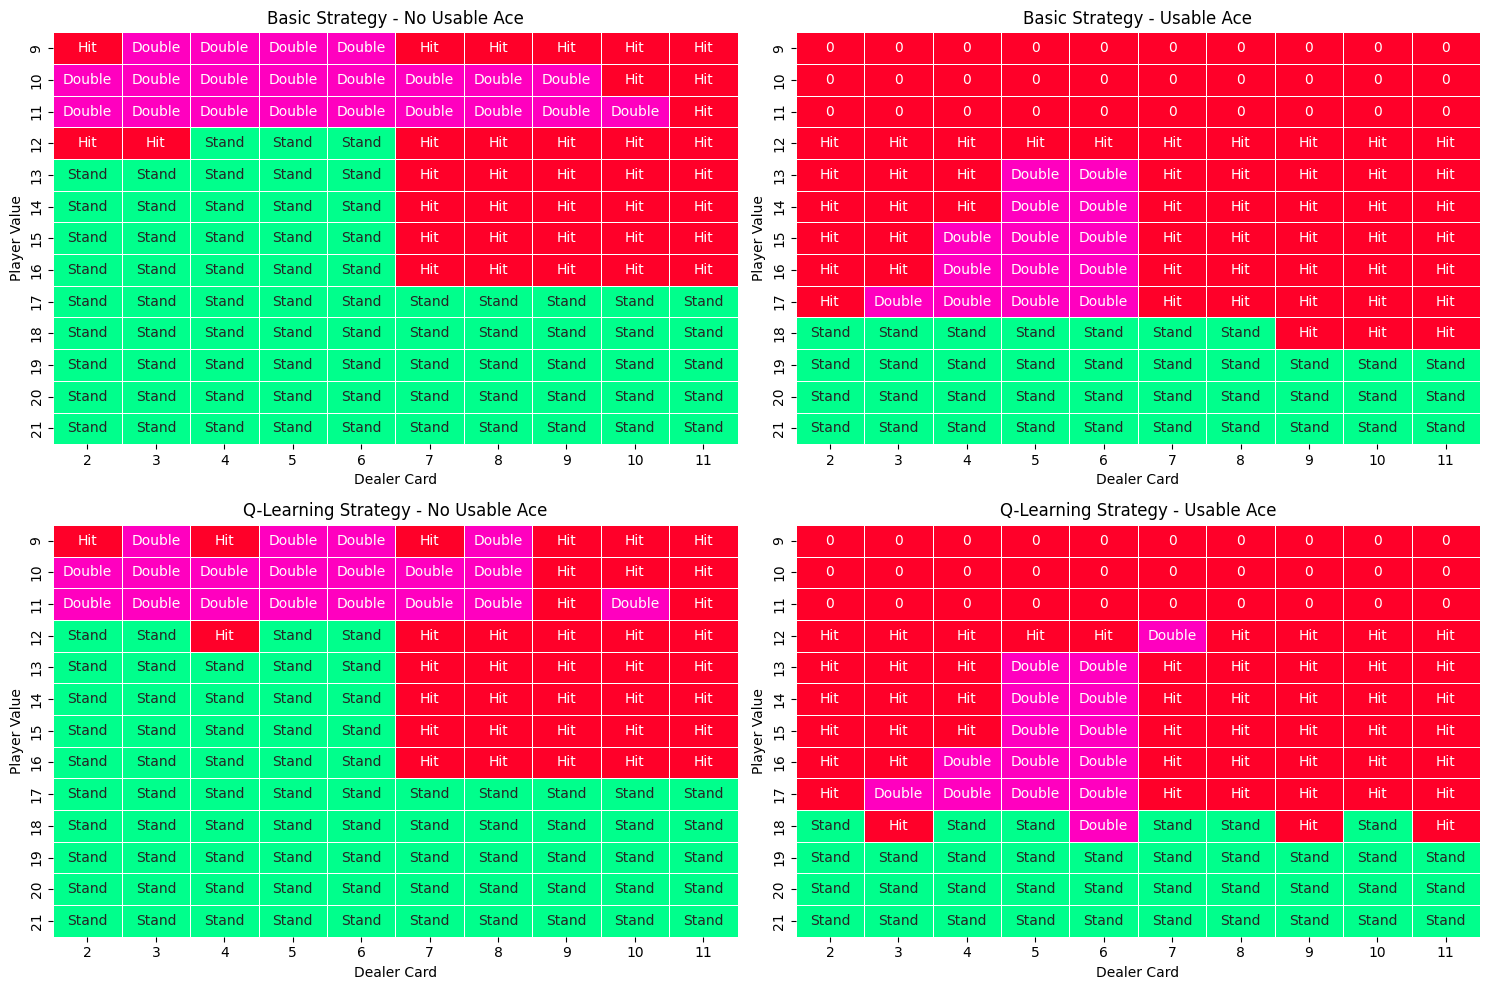

In [69]:
visualize_blackjack_policies("basic_strat_doub.csv", "dq_h_s_dd_strat.csv")